In [1]:
#basic package
import os
import numpy as np
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import math
import pickle #save and load dictionaries/lists
import random
import tqdm

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec, starting_h_day
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
name = 'OFH'

# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
max_date_adaptability = config.max_date_adaptability

change the configuration file if not done yet!


# Download data

In [5]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
#display(df_daily[df_daily.isna().any(axis=1)])
#make sure we have their mvt
df_daily = df_daily[~df_daily['perc_duration_5_Zone'].isnull()]
dico_cl = {'MEXP':'MEXP','LEXP':'LEXP',
           'EPI':'REXP','LEXPLOST':'REXP','MEXPLOST':'REXP','NewAfterEpiLOST':'REXP','NewAfterEpi':'REXP'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cl[x])
display(df_daily['CLASS'].value_counts())
#show columns with max amount of nan
display(df_daily.isna().sum(axis=0).sort_values())
print(df_daily.shape)
display(df_daily.head(3))
print(min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist()))
df_doa = df_daily[['level','DIB','WIB','DOA','WOA']].drop_duplicates()
#remove days when night is not available
df_daily = df_daily[~df_daily['is_mvt_night'].isnull()]
df_doa.sort_values(['level']).head(10)

REXP    22762
MEXP     9174
LEXP     7446
Name: CLASS, dtype: int64

HenID                                                0
nbr_stays_4_Zone                                     0
nbr_stays_5_Zone                                     0
nbr_stays_2_Zone                                     0
PenID                                                0
                                                 ...  
mid_cum_Z4_sec_Morning                            5991
vertical_travel_distance_fulllight_perinsideh     6608
R-Pen                                            11034
FirstTimestamp_1_Zone_sec                        14495
FirstTimestamp_1_Zone                            14495
Length: 82, dtype: int64

(39382, 82)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,weight_interp,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00,0.000000,540.000000,True
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,13.00,5.416667,521.583333,False
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,3.433333,4.15,2.166667,530.250000,False


17 60


,level,DIB,WIB,DOA,WOA
3,2020-09-30,1,1,119,17
4,2020-10-01,2,1,120,18
5,2020-10-02,3,1,121,18
14850,2020-10-03,4,1,122,18
6,2020-10-04,5,1,123,18
0,2020-10-05,6,1,124,18
1,2020-10-06,7,1,125,18
2,2020-10-07,8,2,126,18
10,2020-10-10,11,2,129,19
11,2020-10-11,12,2,130,19


#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

# Add variables for this chapter only

In [6]:
# We need list_Zall...
df_daily_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily_init = df_daily_init[df_daily_init['level']!=dt.datetime(2021,7,25)]
print(df_daily_init.shape)
df_daily_init.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


In [7]:
df_daily['level_'] = df_daily['level'].map(lambda x: dt.datetime(x.year, x.month, x.day))
df_daily_init['level_'] = df_daily_init['level'].map(lambda x: dt.datetime(x.year, x.month, x.day))
print(df_daily.shape)
df_daily = pd.merge(df_daily, df_daily_init[['HenID','level_','list_ZALL']], on=['HenID','level_'], how='left')
print(df_daily.shape, df_daily_init.shape)

(38932, 83)
(38932, 84) (39382, 71)


,FirstTimestamp_1_Zone,level,verification_daily_total_nbr_hour,duration_1_Zone_min
0,NaN,2020-10-05,9.0,NaN
1,NaN,2020-10-06,9.0,NaN
2,NaN,2020-10-07,9.0,NaN


,FirstTimestamp_1_Zone,level,verification_daily_total_nbr_hour,duration_1_Zone_min
38799,NaN,2021-02-14,15.0,NaN
38802,NaN,2021-02-17,15.0,NaN
38818,NaN,2021-03-06,15.0,0.0
38838,NaN,2021-03-26,15.0,0.0
38889,NaN,2021-05-21,15.0,NaN


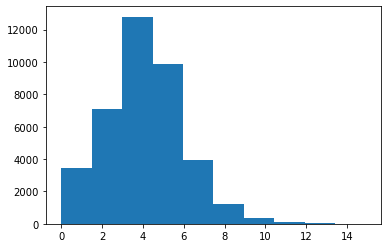

In [8]:
# add vertical distance /inside hour (not that when the wg is close the duarion is nan, and the division will be nan (note that 
#when a bird did not go outdside it should  be 0, not nan), so we controlled for this too)
#small check. dt.datetime(2021,2,14,0,0,0) & dt.datetime(2021,2,17,0,0,0) & dt.datetime(2021,5,21,0,0,0) WG was closed, but 
#not 2021-03-06 --> looks good
display(df_daily[df_daily['FirstTimestamp_1_Zone'].isnull()][['FirstTimestamp_1_Zone','level','verification_daily_total_nbr_hour',
                                                      'duration_1_Zone_min']].head(3))
display(df_daily[df_daily['FirstTimestamp_1_Zone'].isnull()][['FirstTimestamp_1_Zone','level','verification_daily_total_nbr_hour',
                                                      'duration_1_Zone_min']].tail(5))
df_daily['vertical_travel_distance_perinsideh'] = df_daily.apply(lambda x: x['vertical_travel_distance']/(x['verification_daily_total_nbr_hour']-x['duration_1_Zone_min']/60) \
                                                                 if not math.isnan(x['duration_1_Zone_min']) else x['vertical_travel_distance']/x['verification_daily_total_nbr_hour'],axis=1)
plt.hist(df_daily['vertical_travel_distance_perinsideh']);

,level,verification_daily_total_nbr_hour,day_lighth
0,2020-10-05,9.0,9
1,2020-10-06,9.0,9
2,2020-10-07,9.0,9
3,2020-09-30,8.0,9
4,2020-10-01,9.0,9
...,...,...,...
38927,2021-07-20,15.0,2
38928,2021-07-21,15.0,2
38929,2021-07-22,15.0,2
38930,2021-07-23,15.0,2


9.0


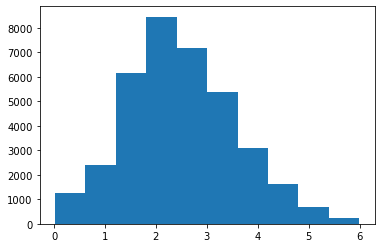

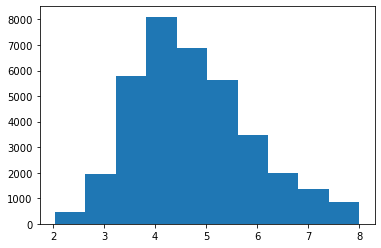

In [9]:
#add mid-nestbox usage morning (from light on until 8!)
df_daily['day_lighth'] = df_daily['level'].map(lambda x: starting_h_day(x, config.dico_night_hour))
#small verification
display(df_daily[['level','verification_daily_total_nbr_hour','day_lighth']])
#mid-time Z4 ONLY MORNING
print(len(eval(df_daily['list_ZALL'].iloc[1]))/60/60)
#find mid number of seconds after the light was turned on of the morning usage (i.e. until 8h in the morning)
df_daily['mid_durationafterlightturnedon_Z4_h_Morning'] = df_daily.apply(lambda x: mid_cum_Z4_sec(eval(x['list_ZALL'])[0:((8-x['day_lighth'])*60*60)])/60/60 if x['day_lighth']<8 else np.nan, axis=1)
df_daily['mid_cum_Z4_h_Morning'] = df_daily.apply(lambda x: x['mid_durationafterlightturnedon_Z4_h_Morning']+x['day_lighth'], axis=1)
plt.hist(df_daily['mid_durationafterlightturnedon_Z4_h_Morning'])
plt.show()
plt.hist(df_daily['mid_cum_Z4_h_Morning']);

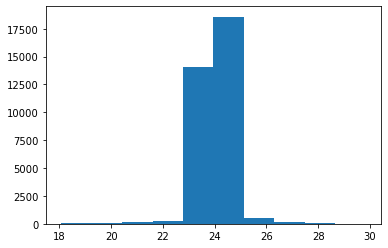

In [10]:
#add interval time between two days of the mid nestbox zone usage
#not efficient, but small data so I'd rather keep it short in lines than short in time here (takes 1mn to run)
df_daily['previous_mid_cum_Z4_h_Morning'] = df_daily.apply(lambda x: df_daily[(df_daily['HenID']==x['HenID'])&\
                                                                              (df_daily['level']==x['level']-dt.timedelta(days=1))]['mid_cum_Z4_h_Morning'].values, axis=1)
df_daily['previous_mid_cum_Z4_h_Morning'] = df_daily['previous_mid_cum_Z4_h_Morning'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_daily['Intervaltime_midcumZ4hmorning_h'] = df_daily.apply(lambda x: 24+(x['mid_cum_Z4_h_Morning']-x['previous_mid_cum_Z4_h_Morning']) if not math.isnan(x['previous_mid_cum_Z4_h_Morning']) else np.nan, axis=1)
#small check
df_daily[df_daily['HenID']=='hen_1'][['level','mid_cum_Z4_h_Morning','previous_mid_cum_Z4_h_Morning','Intervaltime_midcumZ4hmorning_h']].tail(5)
plt.hist(df_daily['Intervaltime_midcumZ4hmorning_h']);

#Note: mid_durationafterlightturnedon_Z4_h_Morning: should be used rather than mid_cum_Z4_h_Morning, if the light was not 
#turned on at a same time always, when turned on before 8h

In [15]:
#add vaccination days selected from previous chapter
li_vacc = [dt.datetime(2020,12,30), dt.datetime(2021,3,9), dt.datetime(2021,5,7)]
df_daily['is_vacc'] = df_daily['level'].map(lambda x: x in li_vacc)

In [19]:
df_daily_ = df_daily.drop(['list_ZALL'],axis=1)
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified_OFH.csv'),sep=';',index=False)
print(df_daily_.shape)
df_daily_.head(3)

(38932, 89)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,level_,vertical_travel_distance_perinsideh,day_lighth,mid_durationafterlightturnedon_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h,is_vacc
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,0.000000,540.000000,True,2020-10-05,0.000000,9,NaN,NaN,NaN,False
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,5.416667,521.583333,False,2020-10-06,0.444444,9,NaN,NaN,NaN,False
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,2.166667,530.250000,False,2020-10-07,0.444444,9,NaN,NaN,NaN,False
